In [3]:
import numpy as np
import pandas as pd
from skcuda import cublas
from pycuda import gpuarray
import pycuda.autoinit
import time
from pycuda.compiler import SourceModule
import pycuda.driver as cuda


get_square = SourceModule(
'''
__global__ void x_square(float *x, int &n)
{
    const int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if(idx<n)
        x[idx] = x[idx] * x[idx];
}

__global__ void y_square(float *y, int &m)
{
    const int idx = threadIdx.x;
    if(idx<m)
        y[idx] = y[idx] * y[idx];

}
'''
)
# 这个函数我还没想好怎么写，先写一个简易版的
square_sum = SourceModule(
'''

__global__ void sum_row_x(float *s_x, float *self_sum1, int &numSample, int &k, int &dim)
{
    const int idx1 = threadIdx.x + blockIdx.x * blockDim.x;
    //const int idx2 = threadIdx.y + blockIdx.y * blockDim.y;

    //先自己行求和
    if(idx1 < numSample)
    {
        for(int i=0;i<dim;i++)
    {
        self_sum1[idx1] += s_x[idx1*dim+i];
    }
    __syncthreads();    
    }

    
    
}
__global__ void sum_row_y(float *s_y, float *self_sum2, int &numSample, int &k, int &dim)
{
    //const int idx1 = threadIdx.x + blockIdx.x * blockDim.x;
    const int idx2 = threadIdx.y + blockIdx.y * blockDim.y;

    //先自己行求和
    if(idx2 < k)
    {
       for(int j=0;j<dim;j++)
    {
        self_sum2[idx2] += s_y[idx2*dim+j];
    }
    __syncthreads();     
    }

    
}

__global__ void sum_total(float *self_sum1, float *self_sum2, float *result, int &k, int &numSample)
{
    const int idx1 = threadIdx.x + blockIdx.x * blockDim.x;
    //const int idx2 = threadIdx.y + blockIdx.y * blockDim.y;
    
    if(idx1 < numSample)
    {
    for(int i=0; i<k;i++)
    {
    result[i+idx1*k] = self_sum1[idx1] + self_sum2[i];
    //flattened
    }
    __syncthreads();        
    }
 

}

'''
)
# matrix1 is dataset, matrix2 is centroids
#数据点得分批去输
def get_xy_square(matrix1, matrix2, cluster_k):
    n = matrix1.shape[0]*matrix1.shape[1]
    grid_dim = n // 512 + 1
    n = np.int32(n)
    n_gpu = cuda.mem_alloc(n.nbytes)
    cuda.memcpy_htod(n_gpu, n)

    x = matrix1.flatten().astype(np.float32)
    x_gpu = cuda.mem_alloc(x.nbytes)
    cuda.memcpy_htod(x_gpu, x)
    x_func = get_square.get_function("x_square")
    
    # we have a flexible block assignment
    x_func(x_gpu, n_gpu, block=(512,1,1), grid=(grid_dim,1))
    # you can print the variables if you want
    cuda.memcpy_dtoh(x, x_gpu)
    x = np.reshape(x, (matrix1.shape[0], matrix1.shape[1]))
    
    m = matrix2.shape[0] * matrix2.shape[1]
    # determining grid size
    if(m>512):
        grid_dim = m // 512 + 1
    else:
        grid_dim = 1
    m = np.int32(m)
    m_gpu = cuda.mem_alloc(m.nbytes)
    cuda.memcpy_htod(m_gpu, m)

    y = matrix2.flatten().astype(np.float32)
    y_gpu = cuda.mem_alloc(y.nbytes)
    cuda.memcpy_htod(y_gpu, y)
    y_func = get_square.get_function("y_square")
    

    y_func(y_gpu, m_gpu, block=(512,1,1), grid=(grid_dim,1))
    # you can print the variables if you want 
    cuda.memcpy_dtoh(y, y_gpu)
    y = np.reshape(y, (matrix2.shape[0], matrix2.shape[1]))
    
    self_sum1 = np.zeros((matrix1.shape[0], ), dtype = np.float32)
    block_dim = len(self_sum1) // 512 + 1
    self_sum2 = np.zeros((matrix2.shape[0], ), dtype = np.float32)
    self_sum1_gpu = cuda.mem_alloc(self_sum1.nbytes)
    self_sum2_gpu = cuda.mem_alloc(self_sum2.nbytes)
    cuda.memcpy_htod(self_sum1_gpu, self_sum1)
    cuda.memcpy_htod(self_sum2_gpu, self_sum2)
    
    
    numSample = np.int32(matrix1.shape[0])
    numSample_gpu = cuda.mem_alloc(numSample.nbytes)
    cuda.memcpy_htod(numSample_gpu, numSample)
    
    k = np.int32(cluster_k)
    k_gpu = cuda.mem_alloc(k.nbytes)
    cuda.memcpy_htod(k_gpu, k)
    
    dim = np.int32(matrix1.shape[1])
    dim_gpu = cuda.mem_alloc(dim.nbytes)
    cuda.memcpy_htod(dim_gpu, dim)

    result = np.zeros((matrix2.shape[0]*matrix1.shape[0], ), dtype = np.float32)
    block_dim_result = len(result) // 512 + 1
    result_gpu = cuda.mem_alloc(result.nbytes)
    cuda.memcpy_htod(result_gpu, result)

    sum_func_row_x = square_sum.get_function("sum_row_x")

    sum_func_row_x(x_gpu, self_sum1_gpu, numSample_gpu, k_gpu, dim_gpu, block = (512, 1, 1), grid = (block_dim,1))

    sum_func_row_y = square_sum.get_function("sum_row_y")
    sum_func_row_y(y_gpu, self_sum2_gpu, numSample_gpu, k_gpu, dim_gpu, block = (1, int(cluster_k + 1), 1), grid = (1,1))

    sum_func_total = square_sum.get_function("sum_total")
    sum_func_total(self_sum1_gpu, self_sum2_gpu, result_gpu, k_gpu, numSample_gpu, block=(512,1,1), grid=(block_dim_result,1))

    result_cpu = np.empty_like(result)
    cuda.memcpy_dtoh(result_cpu, result_gpu)
    result_cpu = np.reshape(result_cpu, (matrix1.shape[0], matrix2.shape[0]))
    result_cpu = np.transpose(result_cpu)
    
    return result_cpu
check = SourceModule(
   '''
__global__ void check_if_valid(float *g_data, int &length){
    float temp_data[512]={0};
    
    unsigned int tid = threadIdx.x;
    unsigned int i= blockIdx.x*blockDim.x+ threadIdx.x;
    if(tid < length)
    {
    temp_data[tid] = g_data[i];
    }
    __syncthreads();    
    if (tid < length)     
    g_data[i] = (temp_data[tid] > 0)? temp_data[tid]:0;
    
    __syncthreads();
    }
  
   '''
)
# matrix 1 is centroids, matrix 2 is dataset.transpose, matrix 3 is result
def dis_computation(matrix1, matrix2, matrix3):
    
    matrix1 = matrix1.astype(np.float32)
    matrix2 = matrix2.astype(np.float32)
    matrix3 = matrix3.astype(np.float32)
    
    ldc = matrix3.shape[1]
    m = matrix2.shape[1]
    n = matrix1.shape[0]
    C = matrix3.flatten()
    #print(C)
    #the above is matrix C
    ldb = matrix1.shape[1]
    k = matrix1.shape[1]
    B = matrix1.flatten()
    #the above is matrix B

    lda = matrix2.shape[1]
    A = matrix2.flatten()
    # the above is matrix A
    transa = 'n'
    transb = 'n'
    alpha = -2
    beta = 1
    #copy data into GPU
    A_gpu = gpuarray.to_gpu(A)
    B_gpu = gpuarray.to_gpu(B)
    C_gpu = gpuarray.to_gpu(C)
    # computing matrix
    h = cublas.cublasCreate()
    cublas.cublasSgemm(h, transa, transb, m, n, k, alpha, A_gpu.gpudata, lda, B_gpu.gpudata, ldb, beta, C_gpu.gpudata, ldc)
    cublas.cublasDestroy(h)
    
    C = C_gpu.get()

    check_func = check.get_function("check_if_valid")
    length = np.int32(n)
    length_gpu = cuda.mem_alloc(length.nbytes)
    cuda.memcpy_htod(length_gpu, length)
    check_func(cuda.InOut(C),length_gpu,block=(n,1,1),grid=(m,1))  
    
    C = np.reshape(C, (n, m))
    C = C.transpose() # 1484 * 10 or 494021 * 5
    #死亡比较（可以用GPU并行化做，check_if_valid），这个函数大概总体会耗费一秒钟

    C = np.sqrt(C)

    return C
def cluster_assignment(C):
# 实质上这里也是在排序
    minDist = np.amin(C, axis = 1)
    minDistIdx = np.argmin(C, axis = 1)
    
    cluster_assignment = np.zeros((len(minDistIdx),2))
    #for i in range(len(minDistIdx)):
    cluster_assignment[:,0] = minDistIdx
    cluster_assignment[:,1] = minDist ** 2
    
    return cluster_assignment

In [4]:
import ThrustRTC as trtc
# 下面两个函数是老版本
def sort_by_key(clusterAssment):
    cluster = clusterAssment[:,0].astype(np.float32)
    cluster_gpu = trtc.device_vector_from_numpy(cluster)
    n = cluster_gpu.size()
    index = trtc.device_vector("int32_t", n)
    trtc.Sequence(index)
    trtc.Sort_By_Key(cluster_gpu, index)
    index_cpu = index.to_host()
    cluster_cpu = cluster_gpu.to_host()
    dict = {}
    for key in cluster_cpu:
        dict[key] = dict.get(key, 0) + 1
    return index_cpu, cluster_cpu, dict
#这里感觉又在做遍历
def sort(index_cpu, cluster_cpu, placement, dataset, dict):
    data_in_cluster = []
    cluster_list = cluster_cpu.tolist()
    start = cluster_list.index(placement)
    end = start + dict[placement]
    data_in_cluster = dataset[index_cpu[start:end],:]
    data_in_cluster = np.array(data_in_cluster)
    return data_in_cluster
# 下面两个函数是新版本
def sort_by_key_without_count(clusterAssment):
    cluster = clusterAssment[:,0].astype(np.float32)
    cluster_gpu = trtc.device_vector_from_numpy(cluster)
    n = cluster_gpu.size()
    index = trtc.device_vector("int32_t", n)
    trtc.Sequence(index)
    trtc.Sort_By_Key(cluster_gpu, index)
    index_cpu = index.to_host()
    cluster_cpu = cluster_gpu.to_host()
    return index_cpu, cluster_cpu

# shared_memory.max()=48KB(12000 int/float32)
find = SourceModule(
'''
__global__ void find_range(float *cluster, float *result)
{
    __shared__ float sdata[512];
    unsigned int tid = threadIdx.x;
    unsigned int i = blockIdx.x*blockDim.x+ threadIdx.x;
    sdata[tid] = cluster[i];
    __syncthreads();
    if(sdata[tid] != sdata[tid+1] and tid < 499)
        result[int(sdata[tid])] = i+1;
    __syncthreads();
}

__global__ void find_minimum(float *list, float *result_value, int &length)
{
    __shared__ float sdata[512];
    unsigned int tid = threadIdx.x;
    unsigned int i = blockIdx.x * blockDim.x + threadIdx.x;    
    if(tid < length)
    {
    sdata[tid] = list[i];    
    }

    __syncthreads();
    if(tid < length)
        for(unsigned int s=blockDim.x/2; s>0; s>>=1) {
        if (tid < s)
        {
        sdata[tid] = (sdata[tid] < sdata[tid + s])? sdata[tid] : sdata[tid + s];        
        }
        __syncthreads();
        }
    if(tid == 0)
    result_value[blockIdx.x] = sdata[0]; 

}
__global__ void find_minimum_index(float *list, int *result_idx, int &length)
{
    __shared__ float sdata[512];
    __shared__ int ssdata[512];
    unsigned int tid = threadIdx.x;
    unsigned int i= blockIdx.x*blockDim.x+ threadIdx.x;    
    if(tid < length)
    {
    sdata[tid] = list[i];
    ssdata[tid] = tid;
    }

    __syncthreads();
    if(tid < length)
        for(unsigned int s=blockDim.x/2; s>0; s>>=1) {
        if (tid < s) 
            ssdata[tid] = (sdata[tid] < sdata[tid + s])? ssdata[tid]:ssdata[tid+s];
            __syncthreads();
        if(tid < s)
            sdata[tid] = (sdata[tid] < sdata[tid + s])? sdata[tid]:sdata[tid+s];    
            __syncthreads();
        }

    if(tid == 0)
    result_idx[blockIdx.x] = ssdata[0];
}
'''
)
def sort_gpu(index_cpu, cluster_cpu, dataset, k, placement):
    cluster1 = cluster_cpu[0:250000].astype(np.float32)
    cluster2 = cluster_cpu[250000:-1].astype(np.float32)
    result1 = np.zeros((k-1,),dtype=np.float32)
    result2 = np.zeros((k-1,),dtype=np.float32)
    find_func = find.get_function("find_range")
    find_func(cuda.In(cluster1),cuda.Out(result1), block=(500,1,1),grid=(500,1))
    find_func(cuda.In(cluster2),cuda.Out(result2), block=(500,1,1),grid=(500,1))
    # 取置信值，这里的代码可以优化一下
    # 如果数据量控制在25w以内效果最佳
    for j in range(len(result2)):
        if(result2[j] != 0):
            result2[j] += 250000
    for i in range(len(result2)-1):
        if(result2[i] > result2[i+1]):
            result2[i] = 0
    starting_points = [0]
    for jj in range(len(result2)):
        starting_points.append(max(result1[jj], result2[jj]))
    starting_points.append(dataset.shape[0]+1)
    data_in_cluster = []
    start = int(starting_points[placement])
    end = int(starting_points[placement+1])
    data_in_cluster = dataset[index_cpu[start:end],:]
    data_in_cluster = np.array(data_in_cluster)
    return data_in_cluster

def cluster_assignment_gpu(C):
    C = C.astype(np.float32)
    length = np.int32(C.shape[1])
    length_gpu = cuda.mem_alloc(length.nbytes)
    cuda.memcpy_htod(length_gpu, length)
    result = np.zeros((C.shape[0],), dtype = np.float32)
    find_func = find.get_function("find_minimum")
    find_func(cuda.In(C),cuda.Out(result),length_gpu,block=(C.shape[1],1,1),grid=(C.shape[0],1))
    #this function is only suitable for data with dimension y greater than 5, there is a modified version below
    #find_func_index = find.get_function("find_minimum_index")
    
    #result_idx = np.zeros((C.shape[0],),dtype = np.int32)

    
    #find_func_index(cuda.In(C), cuda.Out(result_idx), length_gpu, block=(C.shape[1],1,1),grid=(C.shape[0],1))
    
    result_idx = np.argmin(C, axis = 1)    
    cluster_assignment = np.zeros((len(result_idx),2))
    cluster_assignment[:,0] = result_idx
    cluster_assignment[:,1] = result ** 2
    return cluster_assignment
    
#这个函数的进一步优化我还没有想好
def centroids_update(pointsInCluster, k):
    if(pointsInCluster.size == 0):
        return
    dim = pointsInCluster.shape[1]
    length = pointsInCluster.shape[0]
    sum_cpu = []
    for i in range(dim):
        p = pointsInCluster.transpose()[i].astype(np.float32)
        pointsInCluster_test_gpu = trtc.device_vector_from_numpy(p)
        sum_cpu.append(trtc.Reductions.Reduce(pointsInCluster_test_gpu))
    sum_cpu = np.array(sum_cpu)
    kernel = trtc.Kernel(['sum', 'mean', 'dim','length'],
    '''
        const int idx = threadIdx.x;
        if(idx < dim)
            mean[idx] = sum[idx]/length;
    ''')
    sum_gpu = trtc.device_vector_from_numpy(sum_cpu)
    mean_cpu = np.zeros((dim,), dtype = np.float32)
    mean_gpu = trtc.device_vector_from_numpy(mean_cpu)
    kernel.launch(1,dim,[sum_gpu, mean_gpu, trtc.DVInt32(dim), trtc.DVInt32(length)])
    mean_cpu = mean_gpu.to_host()
    return mean_cpu

In [5]:
#k-means++部分也可以用CUDA优化
FLOAT_MAX = 1e10
import random
np.random.seed(1)
random.seed(1)
def get_centroids_gpu(points, k):
    m, n = np.shape(points)
    cluster_centers = np.zeros((k , n))
    # 1、随机选择一个样本点为第一个聚类中心
    index = np.random.randint(0, m)
    cluster_centers[0, ] = np.copy(points[index, ])
    # 2、初始化一个距离的序列
    #d = [0.0 for _ in range(m)]

    for i in range(1, k):
        sum_all = 0
        #for j in range(m):
            # 3、对每一个样本找到最近的聚类中心点
        matrix1 = cluster_centers[0:i,]
        distance_matrix = []
        for pack in range(m // 62000 + 1): # well this is tricky
            subset = points[pack*62000:min(m, (pack+1)*62000)]
            matrix2 = subset.transpose()
            matrix3 = get_xy_square(subset, cluster_centers[0:i,], i)
            distance_matrix.append(dis_computation(matrix1, matrix2, matrix3))
        distance_matrix = np.array(distance_matrix)
        distance_matrix_merge = np.vstack((distance_matrix[0], distance_matrix[1]))
        if(len(distance_matrix) > 2):
            for ii in range(2,len(distance_matrix)):
                distance_matrix_merge = np.vstack((distance_matrix_merge, distance_matrix[ii]))

        distance_matrix_merge = distance_matrix_merge.reshape((m, i))           
        d = np.amin(distance_matrix_merge, axis = 1)
            # 4、将所有的最短距离相加
        sum_all = np.sum(d)
        # 5、取得sum_all之间的随机值
        sum_all *= random.random()
        # 6、获得距离最远的样本点作为聚类中心点
        for j, di in enumerate(d):
            sum_all -= di
            if sum_all > 0:
                continue
            cluster_centers[i] = np.copy(points[j, ])
            break
    return cluster_centers

In [6]:
find_minimum = SourceModule(
'''
__global__ void find_min(float *list, float *result_value, int *result_idx, int &length, int &n)
{
    __shared__ float sdata[512];
    __shared__ int ssdata[512];
    unsigned int tid = threadIdx.x;
    unsigned int i= blockIdx.x*blockDim.x+ threadIdx.x;    
    if(tid < length)
    {
    sdata[tid] = list[i];
    ssdata[tid] = tid;
    }
    unsigned int s;    

    __syncthreads();
    if(tid < length)
    {
        for(s = blockDim.x/2; s>0; s>>=1) {
        if (tid < s) 
            ssdata[tid] = (sdata[tid] < sdata[tid + s])? ssdata[tid]:ssdata[tid+s];
            __syncthreads();
        if(tid < s)
            sdata[tid] = (sdata[tid] < sdata[tid + s])? sdata[tid]:sdata[tid+s];    
            __syncthreads();
}
        if(s == 0)
        {
            //int divider = blockDim.x;
            //int n = divider;
            //while(!(divider % 2))
            //{
            //    n = divider / 2;
            //    divider /= 2;
            //}

            ssdata[0] = (sdata[0] < sdata[n-1])? ssdata[0]:ssdata[n-1];
            sdata[0] = (sdata[0] < sdata[n-1])? sdata[0]:sdata[n-1];
            __syncthreads();
        }    
    }

    if(tid == 0)
    {
    result_idx[blockIdx.x] = ssdata[0];
    result_value[blockIdx.x] = sdata[0];     
    }

}
'''
)
def cluster_assignment_new(C):
#对于yeast数据集
    C = C.astype(np.float32)
    C_gpu = cuda.mem_alloc(C.nbytes)
    cuda.memcpy_htod(C_gpu, C)
    length = np.int32(C.shape[1])
    length_gpu = cuda.mem_alloc(length.nbytes)
    cuda.memcpy_htod(length_gpu, length)
    result_value = np.zeros((C.shape[0],),dtype = np.float32)
    result_idx = np.zeros((C.shape[0],),dtype = np.int32)
    result_value_gpu = cuda.mem_alloc(result_value.nbytes)
    result_idx_gpu = cuda.mem_alloc(result_idx.nbytes)
    cuda.memcpy_htod(result_value_gpu, result_value)
    cuda.memcpy_htod(result_idx_gpu, result_idx)
    
    n = C.shape[1]
    divider = C.shape[1]
    while(not(divider % 2)):
        n = divider / 2
        divider /= 2
    n = np.int32(n)
    n_gpu = cuda.mem_alloc(n.nbytes)
    cuda.memcpy_htod(n_gpu, n)
    find_func_hybrid = find_minimum.get_function("find_min")    
    find_func_hybrid(C_gpu, result_value_gpu, result_idx_gpu, length_gpu, n_gpu, block=(C.shape[1],1,1),grid=(C.shape[0],1))
    cluster_assignment = np.zeros((len(result_idx),2))
    cuda.memcpy_dtoh(result_idx, result_idx_gpu)
    cuda.memcpy_dtoh(result_value, result_value_gpu)
    cluster_assignment[:,0] = result_idx
    cluster_assignment[:,1] = result_value ** 2
    return cluster_assignment

In [10]:
import numpy as np
import time
from matplotlib import pyplot
import pandas as pd
from sklearn import metrics
from collections import Counter
import warnings
warnings.filterwarnings('error')  
#np.seterr(divide="ignore",invalid="ignore")
##计算欧式距离
def euclDistance(vector1,vector2):
    return np.sqrt(sum(np.power(vector2-vector1,2)))#power计算次方

##初始化数据的中心点，k表示聚类中心数
##随机生成k个聚类中心
def initCentroids(dataset,k):
    numSample,dim=dataset.shape
    centroids=np.zeros((k,dim))
    for i in range(k):
        #index=int(np.random.uniform(0,numSample))#随机生成数
        index = int(i*10000)
        centroids[i,:]=dataset[index,:]
    return centroids

##kmean算法
def kmeans(dataset,k):
    numSample=dataset.shape[0]
    #生成新的两列数组，保存聚类信息
    # 第一列表示所属聚类中心，第二列表示与中心的误差
    clusterAssment=np.zeros((numSample,2))#这里dtype就默认
    clusterChanged=True
    is_normal=True
## step1 初始化聚类中心
    centroids=initCentroids(dataset,k)
    #centroids=get_centroids_gpu(dataset,k)
    storage = np.zeros((numSample,))
    itr = 0
    t4centupdate = 0
    while (clusterChanged and is_normal):
        itr += 1
        if(itr == 30):
            print("Itineration reaches limit.")
            break
        clusterChanged=False        
        if((storage == clusterAssment[:,0]).all()):
            if((storage == 0).all()):
                clusterChanged = True
            else:
                clusterChanged = False
        else:
            clusterChanged = True
        storage = clusterAssment[:,0]
        #二重循环：对所有数据点，与k个聚类中心计算距离
        #并保存标签与距离
        matrix1 = centroids
        #matrix2 = dataset.transpose()
        #matrix3 = get_xy_square(dataset, centroids, k)
        #distance_matrix = dis_computation(matrix1, matrix2, matrix3)  
        distance_matrix = []
        d = []
        clusterAssment1 = clusterAssment # buffer
        if(numSample > 62000):
            for pack in range(numSample // 62000 + 1): # well this is tricky
                subset = dataset[pack*62000:min(numSample, (pack+1)*62000)]
                matrix2 = subset.transpose()
                matrix3 = get_xy_square(subset, centroids, k)
                distance_matrix.append(dis_computation(matrix1, matrix2, matrix3))
            distance_matrix = np.array(distance_matrix)
            #distance_matrix = np.vstack((distance_matrix[0],distance_matrix[1],distance_matrix[2],distance_matrix[3],distance_matrix[4],distance_matrix[5],distance_matrix[6],distance_matrix[7]))
            distance_matrix_merge = np.vstack((distance_matrix[0], distance_matrix[1]))
            if(len(distance_matrix) > 2):
                for i in range(2,len(distance_matrix)):
                    distance_matrix_merge = np.vstack((distance_matrix_merge, distance_matrix[i]))
        #distance_matrix += dis_computation(matrix1, matrix2, matrix3).tolist()
        #distance_matrix = np.array(distance_matrix)
            distance_matrix_merge = distance_matrix_merge.reshape((numSample, k))
            #np.savetxt("temp.csv",distance_matrix_merge)
            #distance_matrix_merge = np.loadtxt("temp.csv")
            clusterAssment = cluster_assignment(distance_matrix_merge)
        else:
            matrix1 = centroids
            matrix2 = dataset.transpose()
            matrix3 = get_xy_square(dataset, centroids, k)
            distance_matrix = dis_computation(matrix1, matrix2, matrix3)
            clusterAssment = cluster_assignment_new(distance_matrix)
        

## step4 循环结束后更新聚类中心
        start = time.time()
        #index, cluster, count_dict = sort_by_key(clusterAssment)
        index, cluster = sort_by_key_without_count(clusterAssment)
        #collection = []
        for i in range(k):
            comp = np.nonzero(clusterAssment[:,0]==i)[0]
            comp1 = np.nonzero(clusterAssment1[:,0] == i)[0]
            if(len(comp) == len(comp1)):
                if((comp == comp1).all()):
                    continue
                
            #points_In_k_Cluster_Label=np.nonzero(clusterAssment[:,0]==i)[0]
            #pointsInCluster=dataset[points_In_k_Cluster_Label]            
                #pointsInCluster = sort(index, cluster, i, dataset, count_dict)
            pointsInCluster = sort_gpu(index, cluster, dataset, k, i) 
            try:
                centroids[i, :] = np.mean(pointsInCluster, axis=0)
                
            except Warning:
                is_normal = False
                break
        end = time.time()
        t4centupdate += (end-start)
    print(t4centupdate)
    ##循环结束，返回聚类中心和标签信息
    print("Congratulations, cluster complete!")
    return centroids,clusterAssment

if __name__=="__main__":
    # print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    start=time.time()
    ## load data
    dataset=pd.read_csv('kdd_pre_pca_III_to_24.csv',sep=',')
    category_real = dataset.loc[:,["clustering"]]
    #dataset=pd.read_csv("iris.txt", sep=' ')
    #dataset=dataset.loc[:,["Sepal.Length","Sepal.Width","Petal.Length","Petal.Width"]]
    #dataset=dataset.loc[:, ["region-centroid-col","region-centroid-row","region-pixel-count","short-line-density-5","short-line-density-2","vedge-mean","vegde-sd","hedge-mean","hedge-sd","intensity-mean","rawred-mean","rawblue-mean","rawgreen-mean","exred-mean","exblue-mean","exgreen-mean","value-mean","saturation-mean","hue-mean"]]
    #dataset=dataset.loc[:,['duration','protocal_type','service','flag','src_bytes','dst_types','land','wrong_fragment','urgent','hot','num_falied_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_hot_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_error_rate','diff_error_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',\
    #'dst_host_same_src_port_rate','dst_host_diff_src_port_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']]
    dataset=dataset.loc[:,['variable1', 'variable2','variable3','variable4','variable5','variable6','variable7','variable8','variable9',\
                           'variable10','variable11','variable12','variable13','variable14','variable15','variable16','variable17',\
                           'variable18','variable19','variable20','variable21','variable22'\
                           ,'variable23','variable24']]
    #,'variable25','variable26',\
                           #'variable27','variable28','variable29','variable30','variable31','variable32','variable33','variable34','variable35']]

    #dataset=dataset.loc[1:25,["Category 1","Category 2","Category 3","Category 4","Category 5","Category 6","Category 7","Category 8","Category 9","Category 10","Category 11","Category 12","Category 13","Category 14","Category 15","Category 16","Category 17","Category 18","Category 19","Category 20","Category 21","Category 22","Category 23","Category 24"]]
    dataset=np.array(dataset)
    #dataset=dataset * 100000000000
    #train, test = train_test_split(dataset, test_size = 0.2)
    ##  k表示聚类中心数
    k = 5
    centroids,clusterAssment=kmeans(dataset,k)

    end = time.time()
    
    print('algorithm running total time: %2f 秒'%(end-start))
    category_real = np.array(category_real)
    category = []
    for i in range(dataset.shape[0]):
        category.append(category_real[i][0])
    category = np.array(category)
    category_pre = np.array(clusterAssment[:,0], dtype = np.int32)
    real = Counter(category)
    pre = Counter(category_pre)
    print(real)
    print(pre)
    real = real.most_common()
    pre = pre.most_common()
    for j in range(dataset.shape[0]):
        for nn in range(k):
            if(category[j] == real[nn][0]):
                category[j] = int(pre[nn][0])
    ARI = metrics.adjusted_rand_score(category, category_pre)
    AMI = metrics.adjusted_mutual_info_score(category, category_pre)
    print("调整兰德指数为" + str(ARI))
    print("归一化互信息指数为" + str(AMI))
    #pyplot.scatter(dataset[:, 0], dataset[:, 1], c=clusterAssment[:,0])
    #pyplot.scatter(centroids[:, 0], centroids[:, 1], c="white", s=150)
    #pyplot.show()

0.7556817531585693
Congratulations, cluster complete!
algorithm running total time: 4.391428 秒
Counter({2: 391458, 0: 97278, 1: 4107, 4: 1126, 3: 52})
Counter({1: 379293, 4: 40298, 0: 36440, 3: 27296, 2: 10694})
调整兰德指数为0.693044788498759
归一化互信息指数为0.5203168147359207


time for centroids update is 0.014392614364624023 seconds.
time for assignment is 0.004483461380004883 seconds.
Congratulations, cluster complete!
algorithm (for training) total time: 0.105638 秒
Counter({'CYT': 463, 'NUC': 429, 'MIT': 244, 'ME3': 163, 'ME2': 51, 'ME1': 44, 'EXC': 35, 'VAC': 30, 'POX': 20, 'ERL': 5})
Counter({4: 303, 9: 237, 2: 192, 0: 184, 6: 134, 5: 128, 1: 110, 3: 100, 8: 81, 7: 15})
调整兰德指数为0.12475902699575928
归一化互信息指数为0.2266120841454031


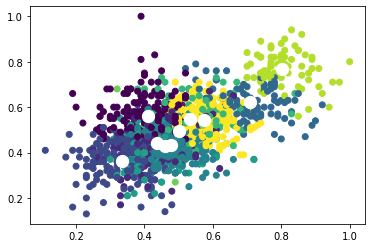

In [12]:
import numpy as np
import time
#import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
from sklearn import metrics
from collections import Counter
import copy
#from sklearn.model_selection import train_test_split
def data_analysis(dataset):
    numSample = dataset.shape[0]
    dim = dataset.shape[1]
##计算欧式距离
def euclDistance(vector1,vector2):
    return np.sqrt(sum(np.power(vector2-vector1,2)))#power计算次方

##初始化数据的中心点，k表示聚类中心数
##随机生成k个聚类中心
def initCentroids(dataset,k):
    numSample,dim=dataset.shape
    centroids=np.zeros((k,dim))
    for i in range(k):
        #index=int(np.random.uniform(0,numSample))#随机生成数
        index = int(i*12)
        centroids[i,:]=dataset[index,:]
    return centroids

##kmean算法
def kmeans(dataset,k):
    numSample=dataset.shape[0]
    #生成新的两列数组，保存聚类信息
    # 第一列表示所属聚类中心，第二列表示与中心的误差
    clusterAssment=np.zeros((numSample,2))#这里dtype就默认
    clusterChanged=True

## step1 初始化聚类中心
    centroids=initCentroids(dataset,k)
    storage = np.zeros((numSample,))
    itr = 0
    t4centupdate = 0
    t4assment = 0
    while (clusterChanged):
        itr += 1
        #print(itr)
        if(itr == 30):
            
            break
        clusterChanged=False
        
        
        if((storage == clusterAssment[:,0]).all()):
            if((storage == 0).all()):
                clusterChanged = True
            else:
                clusterChanged = False
        else:
            clusterChanged = True
        storage = clusterAssment[:,0]
        #二重循环：对所有数据点，与k个聚类中心计算距离
        #并保存标签与距离
        matrix1 = centroids
        matrix2 = dataset.transpose()
        matrix3 = get_xy_square(dataset, centroids, k)
        distance_matrix = dis_computation(matrix1, matrix2, matrix3)
        
        #np.savetxt("temp.csv",distance_matrix)
        #distance_matrix = np.loadtxt("temp.csv")
        start = time.time()
        clusterAssment = cluster_assignment(distance_matrix)
        end = time.time()
        t4assment += (end-start)

## step4 循环结束后更新聚类中心
        start = time.time()
        for j in range(k):
            #nonzero返回数组中非零元素的位置,
            #eg: clusterAssment[:,0] == j
            #array([ True,  True,  True,  True,  True, False])

            points_In_k_Cluster_Label=np.nonzero(clusterAssment[:,0]==j)[0]

            # pointsInCluster=dataset(np.nonzero(clusterAssment[:,0] == j)[0])
            pointsInCluster=dataset[points_In_k_Cluster_Label]
            centroids[j, :] = np.mean(pointsInCluster, axis=0)
        end = time.time()
        t4centupdate += (end-start)
    print("time for centroids update is " + str(t4centupdate) + " seconds.")
    print("time for assignment is " + str(t4assment)+" seconds.")
    ##循环结束，返回聚类中心和标签信息
    print("Congratulations, cluster complete!")
    return centroids,clusterAssment

if __name__=="__main__":
    # print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    start=time.time()
    ## load data
    dataset=pd.read_csv('yeast.txt',sep='\t')
    category_real = dataset.loc[:,["class_protein_localization"]]
    #dataset=pd.read_csv("iris.txt", sep=' ')
    #dataset=dataset.loc[:,["Sepal.Length","Sepal.Width","Petal.Length","Petal.Width"]]
    #dataset=dataset.loc[:, ["region-centroid-col","region-centroid-row","region-pixel-count","short-line-density-5","short-line-density-2","vedge-mean","vegde-sd","hedge-mean","hedge-sd","intensity-mean","rawred-mean","rawblue-mean","rawgreen-mean","exred-mean","exblue-mean","exgreen-mean","value-mean","saturation-mean","hue-mean"]]
    dataset=dataset.loc[:,["mcg","gvh","alm","mit","erl","pox","vac","nuc"]]
    #dataset=dataset.loc[1:25,["Category 1","Category 2","Category 3","Category 4","Category 5","Category 6","Category 7","Category 8","Category 9","Category 10","Category 11","Category 12","Category 13","Category 14","Category 15","Category 16","Category 17","Category 18","Category 19","Category 20","Category 21","Category 22","Category 23","Category 24"]]
    dataset=np.array(dataset)
    #train, test = train_test_split(dataset, test_size = 0.2)
    ##  k表示聚类中心数
    
    k=10
    centroids,clusterAssment=kmeans(dataset,k)

    end = time.time()
    
    print('algorithm (for training) total time: %2f 秒'%(end-start))
    category_real = np.array(category_real)
    category = []
    for i in range(dataset.shape[0]):
        category.append(category_real[i][0])
    category = np.array(category)
    category_pre = np.array(clusterAssment[:,0], dtype = np.int32)
    real = Counter(category)
    pre = Counter(category_pre)
    print(real)
    print(pre)
    real = real.most_common()
    pre = pre.most_common()
    for j in range(dataset.shape[0]):
        for nn in range(k):
            if(category[j] == real[nn][0]):
                category[j] = int(pre[nn][0])
    ARI = metrics.adjusted_rand_score(category, category_pre)
    AMI = metrics.adjusted_mutual_info_score(category, category_pre)
    print("调整兰德指数为" + str(ARI))
    print("归一化互信息指数为" + str(AMI))
    pyplot.scatter(dataset[:, 0], dataset[:, 1], c=clusterAssment[:,0])
    pyplot.scatter(centroids[:, 0], centroids[:, 1], c="white", s=150)
    pyplot.show()